### Regression model for Pumpkin price in USA

This challenge is part of the Machine Learning Course from Microsoft.
The dataset includes 1757 lines of data about the market for pumpkins, sorted into groupings by city. This is raw data extracted from the Specialty Crops Terminal Markets Standard Reports distributed by the United States Department of Agriculture.

Load up required libraries and dataset. Convert the data to a dataframe containing a subset of the data:


1.   Only get pumpkins priced by the bushel
2.   Convert the date to a month
3.   Calculate the price to be an average of high and low prices
4.   Convert the price to reflect the pricing by bushel quantity

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Explore the data

In [ ]:
df = pd.read_csv("US-pumpkins.csv")
df.head()

,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1757 entries, 0 to 1756
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   City Name        1757 non-null   object 
 1   Type             45 non-null     object 
 2   Package          1757 non-null   object 
 3   Variety          1752 non-null   object 
 4   Sub Variety      296 non-null    object 
 5   Grade            0 non-null      float64
 6   Date             1757 non-null   object 
 7   Low Price        1757 non-null   float64
 8   High Price       1757 non-null   float64
 9   Mostly Low       1654 non-null   float64
 10  Mostly High      1654 non-null   float64
 11  Origin           1754 non-null   object 
 12  Origin District  131 non-null    object 
 13  Item Size        1478 non-null   object 
 14  Color            1141 non-null   object 
 15  Environment      0 non-null      float64
 16  Unit of Sale     162 non-null    object 
 17  Quality       

In [ ]:
#Check for missing values

df.isnull().sum()

City Name             0
Type               1712
Package               0
Variety               5
Sub Variety        1461
Grade              1757
Date                  0
Low Price             0
High Price            0
Mostly Low          103
Mostly High         103
Origin                3
Origin District    1626
Item Size           279
Color               616
Environment        1757
Unit of Sale       1595
Quality            1757
Condition          1757
Appearance         1757
Storage            1757
Crop               1757
Repack                0
Trans Mode         1757
Unnamed: 24        1757
Unnamed: 25        1654
dtype: int64

Select columns for price prediction and delete observations with variety null


In [ ]:
columns = ["City Name","Package","Variety","Low Price","High Price","Date"]
df = df.loc[:,columns]
df.dropna(subset=['Variety'],inplace=True)

df.columns

Index(['City Name', 'Package', 'Variety', 'Low Price', 'High Price', 'Date'], dtype='object')

In [ ]:
#Create month & days columns
df["Date"] = pd.to_datetime(df["Date"])
df['Month'] = df['Date'].dt.month

month = pd.DatetimeIndex(df['Date']).month_name()
df['Month_name'] = month

day_of_year = pd.to_datetime(df['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)
df['Day_of_year'] = day_of_year
df

,City Name,Package,Variety,Low Price,High Price,Date,Month,Month_name,Day_of_year
2,BALTIMORE,24 inch bins,HOWDEN TYPE,160.00,160.00,2016-09-24,9,September,267
3,BALTIMORE,24 inch bins,HOWDEN TYPE,160.00,160.00,2016-09-24,9,September,267
4,BALTIMORE,24 inch bins,HOWDEN TYPE,90.00,100.00,2016-11-05,11,November,309
5,BALTIMORE,24 inch bins,HOWDEN TYPE,90.00,100.00,2016-11-12,11,November,316
6,BALTIMORE,36 inch bins,HOWDEN TYPE,160.00,170.00,2016-09-24,9,September,267
...,...,...,...,...,...,...,...,...,...
1752,ST. LOUIS,22 lb cartons,MINIATURE,14.75,14.75,2016-09-30,9,September,273
1753,ST. LOUIS,36 inch bins,MINIATURE,275.00,275.00,2016-09-26,9,September,269
1754,ST. LOUIS,36 inch bins,MINIATURE,275.00,275.00,2016-09-27,9,September,270
1755,ST. LOUIS,36 inch bins,MINIATURE,275.00,275.00,2016-09-28,9,September,271


### Average price of pumpkins in a month

In [ ]:
#Determine average price of pumpkins
avg_price = (df['Low Price'] + df['High Price']) / 2

In [ ]:
df_pumpkins = pd.DataFrame({'City':df['City Name'],'Package': df['Package'],'Variety':df['Variety'],'Low Price': df['Low Price'],'High Price': df['High Price'], 'Price': avg_price,'Month': df['Month'],'Month_name':df['Month_name'],"Day of year":df['Day_of_year']})

df_pumpkins.head()

,City,Package,Variety,Low Price,High Price,Price,Month,Month_name,Day of year
2,BALTIMORE,24 inch bins,HOWDEN TYPE,160.0,160.0,160.0,9,September,267
3,BALTIMORE,24 inch bins,HOWDEN TYPE,160.0,160.0,160.0,9,September,267
4,BALTIMORE,24 inch bins,HOWDEN TYPE,90.0,100.0,95.0,11,November,309
5,BALTIMORE,24 inch bins,HOWDEN TYPE,90.0,100.0,95.0,11,November,316
6,BALTIMORE,36 inch bins,HOWDEN TYPE,160.0,170.0,165.0,9,September,267


### Only get pumpkins priced by the bushel and normalize pricing
If you look at the Package column, pumpkins are sold in many different configurations. Some are sold in '1 1/9 bushel' measures, and some in '1/2 bushel' measures, some per pumpkin, some per pound, and some in big boxes with varying widths.

In [ ]:
df_pumpkins = df_pumpkins[df_pumpkins['Package'].str.contains('bushel',case=True,regex=True)]

df_pumpkins.loc[df['Package'].str.contains('1 1/9'),'Price'] = avg_price/1.1
df_pumpkins.loc[df['Package'].str.contains('1/2'),'Price'] = avg_price*2

df_pumpkins.tail()

,City,Package,Variety,Low Price,High Price,Price,Month,Month_name,Day of year
1738,ST. LOUIS,1/2 bushel cartons,MINIATURE,15.00,15.0,30.00,9,September,273
1739,ST. LOUIS,1/2 bushel cartons,MINIATURE,13.75,15.0,28.75,9,September,273
1740,ST. LOUIS,1/2 bushel cartons,MINIATURE,10.75,15.0,25.75,9,September,273
1741,ST. LOUIS,1/2 bushel cartons,MINIATURE,12.00,12.0,24.00,9,September,273
1742,ST. LOUIS,1/2 bushel cartons,MINIATURE,12.00,12.0,24.00,9,September,273


### Visualization

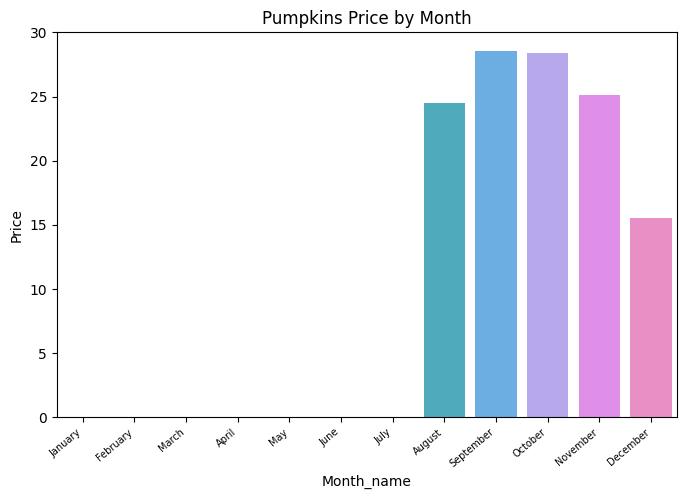

In [ ]:
sns.set_palette("rainbow")
fig,ax = plt.subplots(figsize=(8,5))

sns.barplot(data = df_pumpkins,x="Month_name",y="Price",errorbar=None,order = ["January","February","March","April","May","June","July","August","September","October","November","December"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right",fontsize = '7')

ax.title.set_text("Pumpkins Price by Month")

<Axes: xlabel='Day of year', ylabel='Price'>

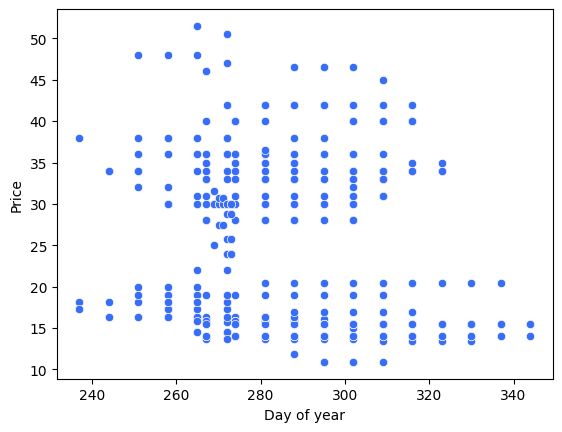

In [ ]:
#Correlation between Price & Day of the year

sns.scatterplot(data=df_pumpkins, x='Day of year', y="Price")


<Axes: xlabel='Day of year', ylabel='Price'>

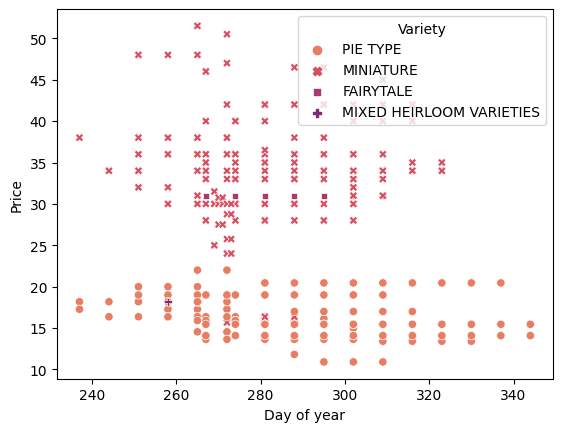

In [ ]:
sns.scatterplot(data=df_pumpkins, x='Day of year', y="Price",hue="Variety",palette="flare",style="Variety")

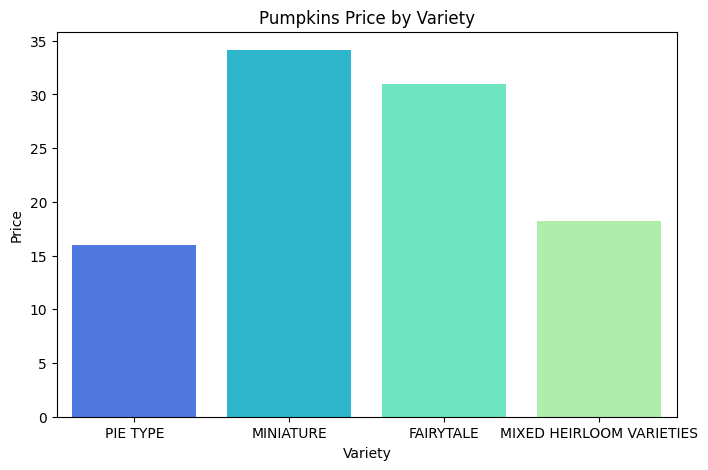

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))

sns.barplot(data = df_pumpkins,x="Variety",y="Price",errorbar=None)

ax.title.set_text("Pumpkins Price by Variety")

### Linear regression with Day of Year



In [ ]:
X = df_pumpkins['Day of year'].to_numpy().reshape(-1,1)
y = df_pumpkins['Price']

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
lreg = LinearRegression()

lreg.fit(X_train,y_train)

LinearRegression()

In [ ]:
#evaluating model

pred = lreg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = lreg.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 10.6 (37.9%)
Model determination:  0.021940482889036717


The model has a big error score so it won´t predict well the values.
Another metric for evaluating the model is Model determination that can be between 0 and 1. The more closer to 1 is,the better the model fits the data.
In our case is 0.4044 so is not good.

Text(0.5, 1.0, 'Test data together VS Regression line ')

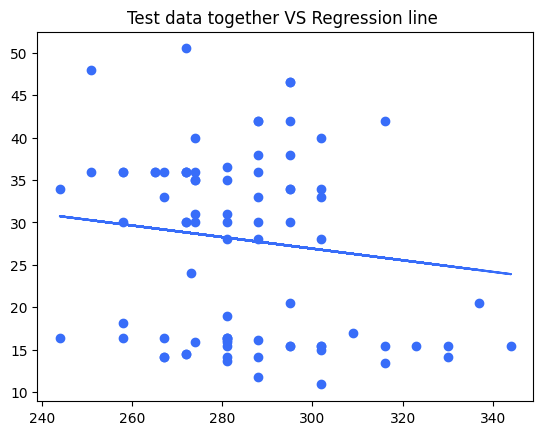

In [ ]:
plt.scatter(X_test,y_test)
plt.plot(X_test,pred)
plt.title("Test data together VS Regression line ")


## Linear Regression with Variety

To take variety into account, we first need to convert it to numeric form, or encode. There are several way we can do it:

*  Simple numeric encoding that will build a table of different varieties, and then replace variety name by an index in that table. This is not the best idea for linear regression, because linear regression takes the numeric value of the index into account, and the numeric value is likely not to correlate numerically with the price.
*   One-hot encoding, which will replace Variety column by 4 different columns, one for each variety, that will contain 1 if the corresponding row is of given variety, and 0 otherwise.


In [ ]:
#one-hot encoding for variety
X = pd.get_dummies(df_pumpkins['Variety'])
y = df_pumpkins['Price']

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
lin_reg = LinearRegression()

lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = lin_reg.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 5.3 (19.9%)
Model determination:  0.7729461721925599


The model determination metric is higher and the error decreased by half but the model could still be further improved.

## Linear Regression with all variables

In [ ]:
X = pd.get_dummies(df_pumpkins['Variety']) \
        .join(df_pumpkins['Month']) \
        .join(pd.get_dummies(df_pumpkins['City'])) \
        .join(pd.get_dummies(df_pumpkins['Package']))
y = df_pumpkins['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lin_reg = LinearRegression()

lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = lin_reg.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 2.84 (10.5%)
Model determination:  0.9401078695963847


 The model shows significant improvement and performs very well with a MSE = 2.84 (10%), and determination 0.94

## Polynomial regression with Day Of Year

---



Polynomial regression creates a curved line to better fit nonlinear data. In our case, if we include a squared DayOfYear variable into input data, we should be able to fit our data with a parabolic curve, which will have a minimum at a certain point within the year.

In [ ]:
X = df_pumpkins['Day of year'].to_numpy().reshape(-1,1)
y = df_pumpkins['Price']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [ ]:
pred = pipeline.predict(X_test)

# calculate MSE and determination
mse_pol_dayofyear = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse_pol_dayofyear/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 2.84 (37.7%)
Model determination:  0.05957799408400666


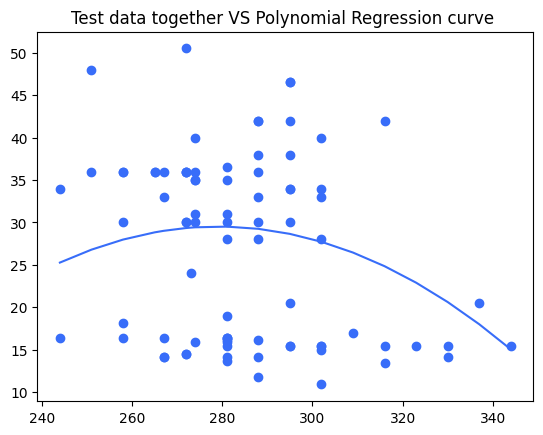

In [ ]:
plt.title("Test data together VS Polynomial Regression curve ")
plt.scatter(X_test,y_test)
plt.plot(sorted(X_test),pipeline.predict(sorted(X_test)))

## Polynomial Regression with All variables


In [ ]:
X = pd.get_dummies(df_pumpkins['Variety']) \
        .join(df_pumpkins['Month']) \
        .join(pd.get_dummies(df_pumpkins['City'])) \
        .join(pd.get_dummies(df_pumpkins['Package']))
y = df_pumpkins['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline = make_pipeline(PolynomialFeatures(2),LinearRegression())
pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 2.51 (9.19%)
Model determination:  0.9554938013125742


# Models results


The best model for pumpkins predictions is with Polynomial Regression using all the variables.

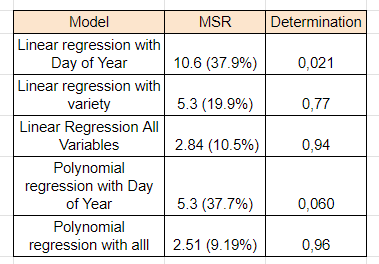